# Exploring TnSeq data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [3]:
def float_convert(x):
    try:
        y = float(x)
    except:
        y = None
    return y

# Load

In [4]:
"""Tn-Seq"""
# Skip these cols
skip_cols = ['orgId', 'locusId', 'sysName', 'desc']
tnseq = pd.read_csv('ecoli_tnseq.tsv', '\t', index_col='geneName')
tnseq = tnseq[[c for c in tnseq if c not in skip_cols]]

# TnSeq t-scores
tscores = pd.read_csv('t_organism_Keio.tsv', '\t', index_col='geneName')
tscores = tscores[[c for c in tnseq if c not in skip_cols]]

# Metadata
md = pd.read_csv('ecoli_md.tsv', '\t')
md['Sample'] = md[['expName', 'expDesc']].apply(lambda x: ' '.join(x), 1)
md['concentration_1'] = md.concentration_1.apply(float_convert)
md['condition'] = md[['aerobic', 'condition_1', 'condition_2']].astype(str).apply(lambda x: '_'.join(x), 1)

# Standardize concentrations 
standardize = lambda x: (x - x.min()) / (x.max() - x.min())
md['standardized_concentration_1'] = md.groupby('condition').concentration_1.apply(standardize)

md.head()

,orgId,expName,expDesc,timeZeroSet,num,nMapped,nPastEnd,nGenic,nUsed,gMed,...,units_3,concentration_3,condition_4,units_4,concentration_4,growthPlate,growthWells,Sample,condition,standardized_concentration_1
0,Keio,set10IT002,"LB, Aerobic",7/20/2015 Keio_ML9_set10,555,954600,0,658766,658236,120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"set10IT002 LB, Aerobic",Aerobic_nan_nan,NaN
1,Keio,set10IT004,LB Aerobic with Phenazine ethosulfate 0.000062...,7/20/2015 Keio_ML9_set10,557,901412,0,630562,630227,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set10IT004 LB Aerobic with Phenazine ethosulfa...,Aerobic_Phenazine ethosulfate_nan,NaN
2,Keio,set10IT005,LB Aerobic with Spiramycin 0.000125 mM,7/20/2015 Keio_ML9_set10,558,1012731,0,705994,705460,120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set10IT005 LB Aerobic with Spiramycin 0.000125 mM,Aerobic_Spiramycin_nan,1.0
3,Keio,set10IT006,LB Aerobic with Spiramycin 0.0000625 mM,7/20/2015 Keio_ML9_set10,559,1051529,0,729527,728846,130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set10IT006 LB Aerobic with Spiramycin 0.000062...,Aerobic_Spiramycin_nan,0.0
4,Keio,set10IT007,LB Aerobic with Oxytetracycline 0.00000125 mM,7/20/2015 Keio_ML9_set10,560,984917,0,733951,732897,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set10IT007 LB Aerobic with Oxytetracycline 0.0...,Aerobic_Oxytetracycline hydrochloride_nan,1.0


# TnSeq overview

## Change in fitness with concentration?

In [31]:
"""Subset to multi-concentration conditions and melt"""
# Multi-concentration conditions
multi_concentration_conditions = md.groupby('condition').filter(lambda x: x.concentration_1.nunique() > 1).condition.unique()
# Subset and melt
melted = tnseq.rename_axis(columns='Sample').stack().reset_index(name='fitness')
# Add some metadata
melted = melted.merge(md.loc[md.condition.isin(multi_concentration_conditions), ['Sample', 'aerobic', 'condition', 'concentration_1', 'standardized_concentration_1']])
# Take mean fitness
mean_melted = melted.groupby(['geneName', 'condition', 'concentration_1', 'standardized_concentration_1']).fitness.mean().reset_index()
mean_melted.head()

,geneName,condition,concentration_1,standardized_concentration_1,fitness
0,GadE,Aerobic_1-ethyl-3-methylimidazolium acetate_nan,30.0,0.0,-0.4870
1,GadE,Aerobic_1-ethyl-3-methylimidazolium acetate_nan,60.0,1.0,-0.5670
2,GadE,Aerobic_1-ethyl-3-methylimidazolium chloride_nan,40.0,0.0,-0.8020
3,GadE,Aerobic_1-ethyl-3-methylimidazolium chloride_nan,80.0,1.0,-1.3510
4,GadE,"Aerobic_2,4-Dinitrophenol_nan",1.0,0.0,0.0255


In [35]:
"""Get top genes and conditions"""
ngenes = 18
nconditions = 20
topgenes = tnseq.mean(1).abs().sort_values(ascending=False).index[:ngenes]
topconditions = melted.groupby('condition').fitness.mean().abs().sort_values(ascending=False).index[:nconditions]
data = mean_melted[mean_melted.geneName.isin(topgenes) & mean_melted.condition.isin(topconditions)]
data.head()

,geneName,condition,concentration_1,standardized_concentration_1,fitness
16636,apaH,"Aerobic_2,4-Dinitrophenol_nan",1.000,0.0,-1.7640
16637,apaH,"Aerobic_2,4-Dinitrophenol_nan",2.000,1.0,-4.9165
16651,apaH,Aerobic_Bacitracin_nan,0.500,0.0,-0.4610
16652,apaH,Aerobic_Bacitracin_nan,1.000,1.0,0.8110
16663,apaH,Aerobic_Cisplatin_nan,0.025,0.0,0.0540


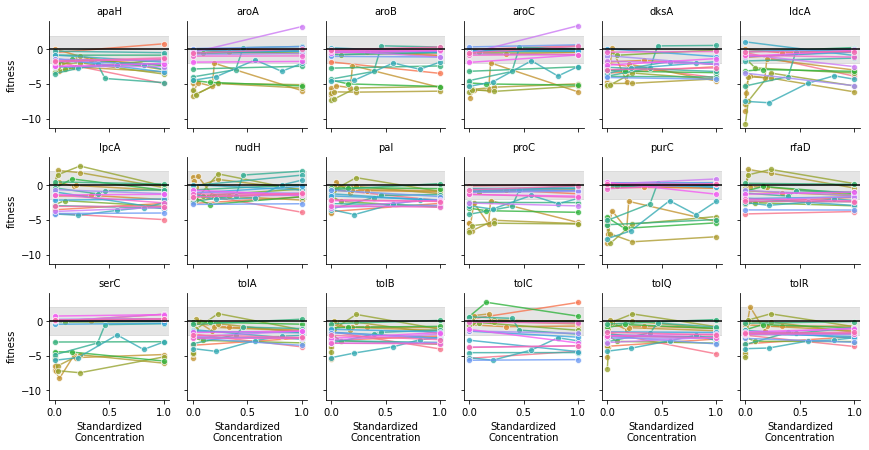

In [41]:
"""Concentration series of top genes and conditions"""
g = sns.relplot(x='standardized_concentration_1', y='fitness', hue='condition', data=data, col='geneName', col_wrap=6, legend=False, height=2, 
                estimator=None, alpha=.8, kind='line', palette='husl', lw=1.5, marker='o')
g.set_titles('{col_name}')
for ax in g.axes.ravel():
    ax.axhspan(-2, 2, color='0.5', alpha=.2)
    ax.axhline(0, color='k')
g.set_xlabels('Standardized\nConcentration')
# plt.savefig(f'ecoli_{ngenes}genes_{nconditions}conditions.pdf', bbox_inches='tight')
plt.show()

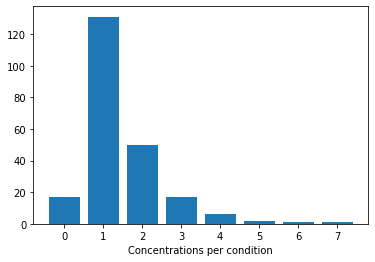

In [55]:
plt.bar(*md.groupby('condition').concentration_1.nunique().value_counts().reset_index().values.T)
plt.xlabel('Concentrations per condition')
plt.show()

# Max fitness per gene, condition
For global overview, look at most extreme case for each experiment

In [4]:
"""Get max fitness per gene, condition"""
# Melt
melted = tnseq.rename_axis(columns='Sample').stack().reset_index(name='fitness')
# Add some metadata
melted = melted.merge(md[['Sample', 'aerobic', 'condition', 'concentration_1']])
# Take mean fitness over concentrations
mean_fitness = melted.groupby(['geneName', 'condition']).fitness.mean().reset_index()
# Pivot
mean_pivotted = mean_fitness.pivot('geneName', 'condition', 'fitness')
mean_pivotted.head()

condition,"Aerobic_1,4-Butanediol_nan",Aerobic_1-Pentanol_nan,Aerobic_1-ethyl-3-methylimidazolium acetate_nan,Aerobic_1-ethyl-3-methylimidazolium chloride_nan,"Aerobic_2,4-Dinitrophenol_nan",Aerobic_2-Furfuraldehyde_nan,Aerobic_2-Mercaptopyridine N-oxide sodium salt_nan,Aerobic_2-Piperidinone_nan,Aerobic_2-nitrobenzenesulfonyl fluoride_nan,Aerobic_2-undecanol_nan,...,Anaerobic_Spectinomycin dihydrochloride pentahydrate_nan,Anaerobic_Spiramycin_nan,Anaerobic_Sulfamonomethoxine_nan,Anaerobic_T7_phage_Kan,Anaerobic_Tetracycline hydrochloride_nan,Anaerobic_Ticarcillin disodium salt_nan,Anaerobic_Trimethoprim_nan,Anaerobic_Vancomycin Hydrochloride from Streptomyces orientalis_nan,Anaerobic_Zinc Pyrithione_nan,Anaerobic_nan_nan
geneName,,,,,,,,,,,,,,,,,,,,,
GadE,0.159,0.287,-0.5270,-1.0765,0.07650,-0.029,0.7035,-0.255,-0.360,0.1325,...,-0.01950,-0.00925,-0.19825,0.242,-0.07975,-0.06275,0.05525,-0.1415,0.02300,0.18392
YdeP,0.099,-0.242,0.0175,-0.0595,0.05450,-0.033,0.0675,-0.163,-0.097,0.0115,...,-0.04725,-0.12650,-0.11875,-0.186,-0.02600,-0.06025,-0.02425,-0.0145,-0.00025,0.04680
aaaE,0.014,-0.386,0.1925,0.2915,-0.04225,0.130,0.3315,-0.105,0.652,-0.1060,...,0.18625,0.15250,0.10225,-0.073,0.12150,0.14725,0.22375,0.1395,0.04250,0.10500
aaeA,-0.032,-0.043,0.0615,0.0155,0.16000,0.107,0.0275,-0.014,-0.034,-0.0760,...,0.09300,0.06650,-0.06950,0.284,0.11275,-0.00800,0.10650,-0.0080,0.11175,0.03172
aaeB,0.100,0.038,-0.0365,-0.0300,-0.34350,-0.205,-0.2450,0.096,0.026,-0.0580,...,0.13725,-0.16400,-0.02100,-0.115,0.12725,0.17075,0.12050,0.0805,0.13950,0.00796


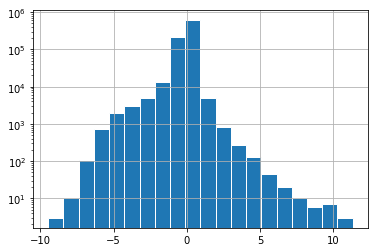

In [66]:
mean_fitness.fitness.hist(bins=20, ec='w')
plt.yscale('log')
plt.show()

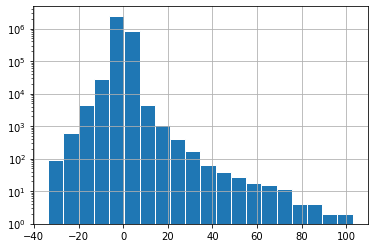

In [7]:
"""Distribution of t scores"""
tscores.stack().hist(bins=20, ec='w')
plt.yscale('log')
plt.show()

In [150]:
"""Condition colors"""
aerobic_colors = dict(zip(md.aerobic.unique(), ['w', 'k']))
groups_to_color = md.media.value_counts()[:10].index

group_colors = dict(zip(groups_to_color, sns.color_palette()))
group_colors.update({g: 'w' for g in md.media.unique() if g not in groups_to_color})

condition_colors = pd.concat([md.set_index('condition')[col].map(colors) for col, colors in zip(['aerobic', 'media'], [aerobic_colors, group_colors])], 1)

In [154]:
md[md.condition.eq('Aerobic_nan_nan')].media.unique()

array(['LB', 'LB_plus_SM_buffer', 'M9_Thauers', 'M9_Thauers_noBiotin',
       'PBS then LB recovery', 'RPMI_with_Fetal_bovine_serum',
       'HEPES_buffer_3mMCaCl2_2mMMgSo4', 'M9', 'M9-D2O'], dtype=object)

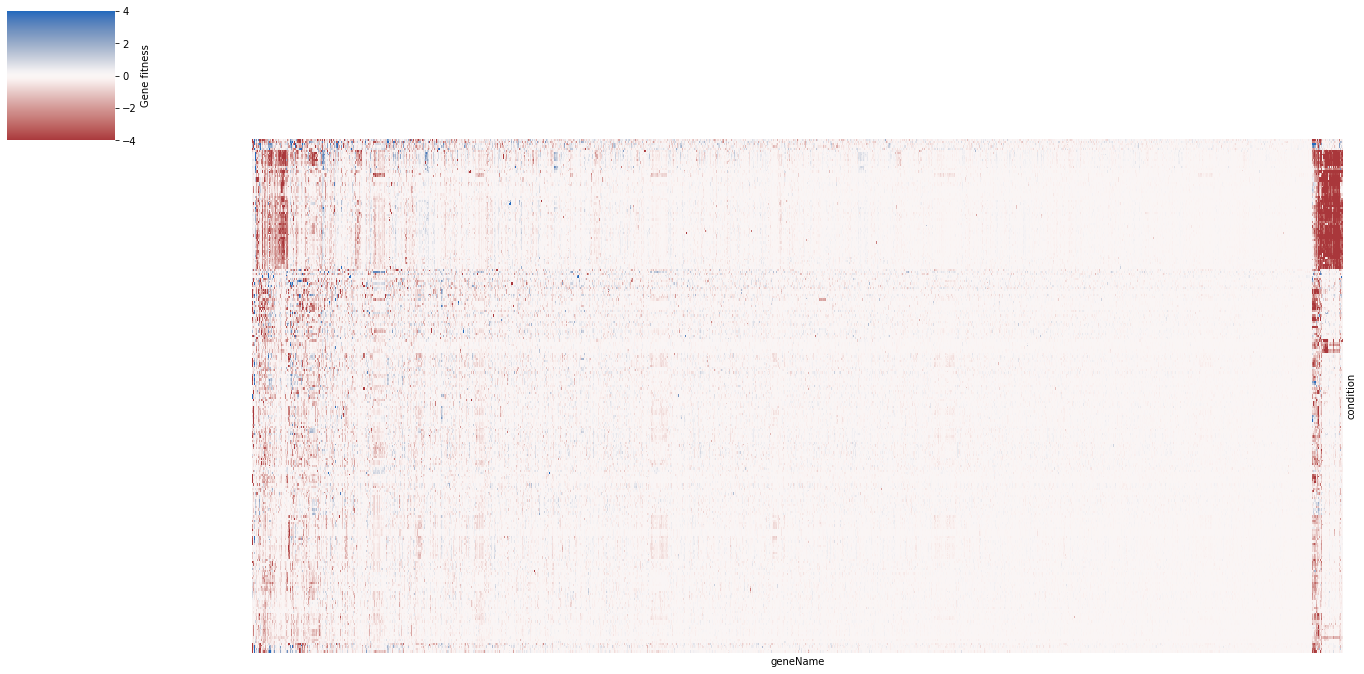

In [155]:
g = sns.clustermap(mean_pivotted.T, figsize=(30, 10), cmap='vlag_r', vmin=-4, vmax=4, colors_ratio=.05, cbar_kws={'label': 'Gene fitness'})
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_dendrogram.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
plt.show()

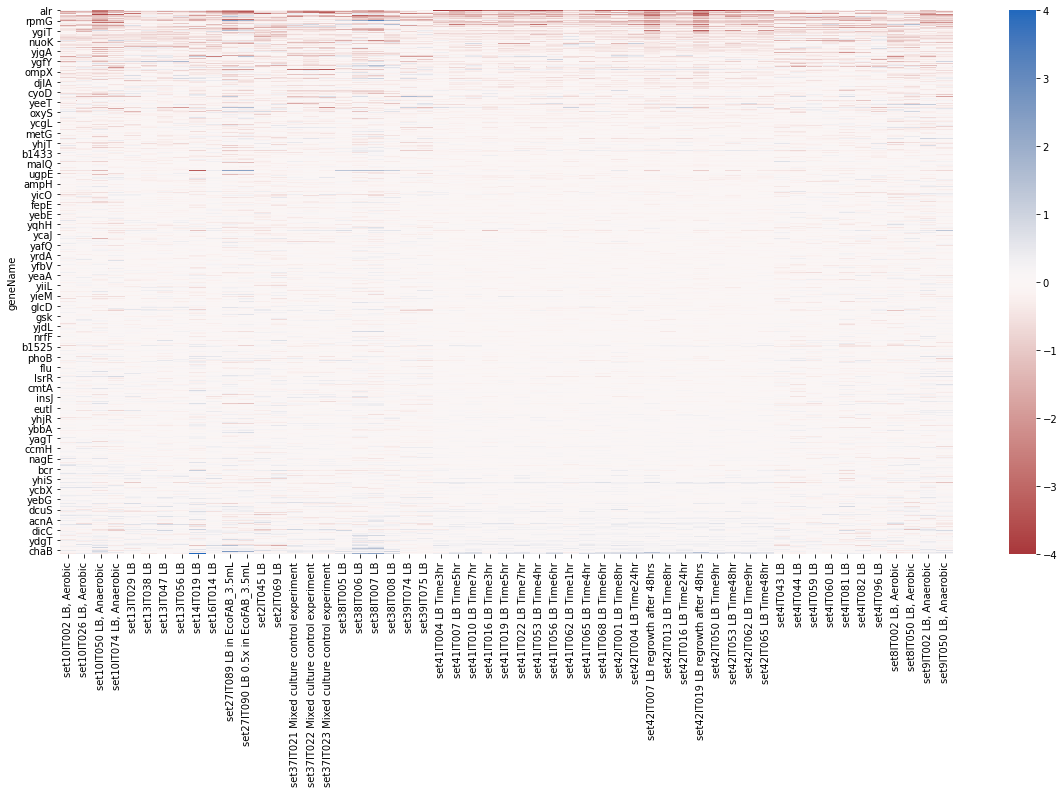

In [4]:
"""Variability within LB media conditions"""
lb_samples = md[md.media.eq('LB') & md.condition_1.isnull() & md.condition_2.isnull()].Sample.unique()
data = tnseq[lb_samples]
order = data.mean(1).sort_values().index
data = data.reindex(order)

plt.figure(figsize=(20, 10))

sns.heatmap(data, vmin=-4, vmax=4, cmap='vlag_r')
plt.show()